# Data Analysis and Cleaning
analysis data and do some dirty work for cleaning
- <a href='#1'>1. data preprocess</a> 
- <a href='#2'>2. analysis user activation by clicking behavior in day unit</a> 
- <a href='#3'>3.analysis creative id clicked by user</a>
- <a href='#4'>4. analysis product category clicked by user</a>
- <a href='#5'>5. analysis ad id clicked by user</a>

In [1]:
# ! pip install imbalanced-learn -i http://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.comImportError: cannot import name '_to_object_array' from 'sklearn.utils' (/opt/conda/lib/python3.7/site-packages/sklearn/utils/__init__.py)
%load_ext autoreload
%autoreload 2
import sys
import os 
import gc
from time import time 
from datetime import timedelta, datetime
import base64

import pandas as pd
from IPython.core.display import display, HTML
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import ks_2samp
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from tqdm import tqdm
from scipy import sparse
from tqdm import tqdm

sys.path.append('../')
import conf
from utils import (
    check_columns, 
    check_nan_value, 
    correct_column_type_by_value_range,
    remove_cont_cols_with_unique_value,
    LogManager,
)

In [2]:
# global settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns',1000)
pd.set_option('display.width',100)
sns.set(rc={'figure.figsize':(20,10)})
LogManager.created_filename = os.path.join(conf.LOG_DIR, 'data_analysis.log')
logger = LogManager.get_logger(__name__)

In [3]:
# global variables
DEFAULT_MISSING_FLOAT = 0

In [4]:
# functions
def __dummy():
    pass

### <a id='1'> 1.data preprocess</a>

In [5]:
! du -sh ../data/*

122M	../data/ad.csv
2.3G	../data/ad_id_window_10_dim_200_sg_1_hs_0_iter_10_embedding.bin
2.3G	../data/ad_id_window_10_dim_200_sg_1_hs_0_iter_10_embedding.npy
249M	../data/ad_id_window_10_dim_200_sg_1_hs_0_iter_10_neural_test_fe_df.feather
244M	../data/ad_id_window_10_dim_200_sg_1_hs_0_iter_10_neural_train_fe_df.feather
63M	../data/ad_id_window_10_dim_200_sg_1_hs_0_iter_10_vocab.pkl
45M	../data/advertiser_id_window_10_dim_200_sg_1_hs_0_iter_10_embedding.bin
45M	../data/advertiser_id_window_10_dim_200_sg_1_hs_0_iter_10_embedding.npy
195M	../data/advertiser_id_window_10_dim_200_sg_1_hs_0_iter_10_neural_test_fe_df.feather
195M	../data/advertiser_id_window_10_dim_200_sg_1_hs_0_iter_10_neural_train_fe_df.feather
1008K	../data/advertiser_id_window_10_dim_200_sg_1_hs_0_iter_10_vocab.pkl
1.9G	../data/click_log.csv
688M	../data/creative_advertiser_ad_id_click_time_mask_window_10_dim_200_sg_1_hs_0_iter_10_neural_train_fe_df.feather
678M	../data/creative_advertiser_ad_id_window_10_dim_200_sg_1_hs_

In [6]:
raw_train_df = pd.read_feather(os.path.join(conf.DATA_DIR,'raw_train_df.feather'))
raw_test_df = pd.read_feather(os.path.join(conf.DATA_DIR, 'raw_test_df.feather'))

In [7]:
raw_train_df.head()

,time,user_id,creative_id,click_times,ad_id,product_id,product_category,advertiser_id,industry,age,gender,y
0,1,1277411,75607,1,69699,8502.0,3,24522,6.0,4,1,3
1,1,1204498,10192,1,11649,1356.0,2,9761,261.0,9,2,18
2,1,1922994,89388,1,81769,NaN,18,26046,54.0,4,1,3
3,1,2720269,225863,1,202691,NaN,18,2003,40.0,4,1,3
4,1,2720269,184810,1,165711,NaN,18,22606,54.0,4,1,3


In [8]:
raw_train_df.dtypes

time                    int8
user_id                int64
creative_id            int64
click_times            int16
ad_id                  int32
product_id           float64
product_category    category
advertiser_id          int32
industry            category
age                     int8
gender                  int8
y                       int8
dtype: object

In [9]:
_ = check_nan_value(raw_train_df)

2020-06-30 16:39:55,491 - utils.utils - INFO - check_nan_value开始
2020-06-30 16:39:55,604 - utils.utils - INFO - time - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:39:55,717 - utils.utils - INFO - user_id - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:39:55,828 - utils.utils - INFO - creative_id - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:39:55,942 - utils.utils - INFO - click_times - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:39:56,060 - utils.utils - INFO - ad_id - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:39:56,235 - utils.utils - INFO - product_id - missing_number: 41972925, missing_ratio:41.85%
2020-06-30 16:39:56,351 - utils.utils - INFO - product_category - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:39:56,463 - utils.utils - INFO - advertiser_id - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:39:56,587 - utils.utils - INFO - industry - missing_number: 4239870, missing_ratio:4.23%
2020-06-30 16:39:56,699 - utils.utils - IN

In [10]:
raw_test_df.head()

,time,user_id,creative_id,click_times,ad_id,product_id,product_category,advertiser_id,industry
0,1,3892830,112276,1,101587,NaN,18,8371,54.0
1,1,3530749,14391,1,15775,1261.0,2,10988,6.0
2,1,3711528,208390,1,187259,1261.0,2,10925,6.0
3,1,3711528,236102,1,212289,1261.0,2,19056,98.0
4,1,3998628,90699,1,82895,NaN,18,10955,238.0


In [11]:
raw_test_df.dtypes

time                    int8
user_id                int64
creative_id            int64
click_times            int16
ad_id                  int32
product_id           float64
product_category    category
advertiser_id          int32
industry            category
dtype: object

In [12]:
_ = check_nan_value(raw_test_df)

2020-06-30 16:40:02,811 - utils.utils - INFO - check_nan_value开始
2020-06-30 16:40:02,848 - utils.utils - INFO - time - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:40:02,886 - utils.utils - INFO - user_id - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:40:02,923 - utils.utils - INFO - creative_id - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:40:02,959 - utils.utils - INFO - click_times - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:40:02,995 - utils.utils - INFO - ad_id - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:40:03,067 - utils.utils - INFO - product_id - missing_number: 14028831, missing_ratio:41.77%
2020-06-30 16:40:03,106 - utils.utils - INFO - product_category - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:40:03,143 - utils.utils - INFO - advertiser_id - missing_number: 0, missing_ratio:0.0%
2020-06-30 16:40:03,186 - utils.utils - INFO - industry - missing_number: 1407841, missing_ratio:4.19%
2020-06-30 16:40:03,187 - utils.utils - IN

In [13]:
len(raw_test_df['user_id'].unique())

1000000

In [14]:
len(raw_train_df['user_id'].unique())

3000000

In [15]:
# fill up the missing value for industry and product_id
raw_train_df.head()

,time,user_id,creative_id,click_times,ad_id,product_id,product_category,advertiser_id,industry,age,gender,y
0,1,1277411,75607,1,69699,8502.0,3,24522,6.0,4,1,3
1,1,1204498,10192,1,11649,1356.0,2,9761,261.0,9,2,18
2,1,1922994,89388,1,81769,NaN,18,26046,54.0,4,1,3
3,1,2720269,225863,1,202691,NaN,18,2003,40.0,4,1,3
4,1,2720269,184810,1,165711,NaN,18,22606,54.0,4,1,3


In [16]:
raw_train_df.dtypes

time                    int8
user_id                int64
creative_id            int64
click_times            int16
ad_id                  int32
product_id           float64
product_category    category
advertiser_id          int32
industry            category
age                     int8
gender                  int8
y                       int8
dtype: object

In [17]:
raw_train_df['industry'] = raw_train_df['industry'].astype('float64')
raw_train_df.loc[:,'industry'] = raw_train_df['industry'].fillna(0)
raw_train_df['industry'] = raw_train_df['industry'].astype(int)
raw_train_df.loc[:,'product_id'] = raw_train_df['product_id'].fillna(0)
raw_train_df['product_id'] = raw_train_df['product_id'].astype(int)

In [18]:
raw_test_df['industry'] = raw_test_df['industry'].astype('float64')
raw_test_df.loc[:,'industry'] = raw_test_df['industry'].fillna(0)
raw_test_df['industry'] = raw_test_df['industry'].astype(int)
raw_test_df.loc[:,'product_id'] = raw_test_df['product_id'].fillna(0)
raw_test_df['product_id'] = raw_test_df['product_id'].astype(int)

In [19]:
raw_train_df.dtypes

time                    int8
user_id                int64
creative_id            int64
click_times            int16
ad_id                  int32
product_id             int64
product_category    category
advertiser_id          int32
industry               int64
age                     int8
gender                  int8
y                       int8
dtype: object

In [20]:
raw_test_df.head()

,time,user_id,creative_id,click_times,ad_id,product_id,product_category,advertiser_id,industry
0,1,3892830,112276,1,101587,0,18,8371,54
1,1,3530749,14391,1,15775,1261,2,10988,6
2,1,3711528,208390,1,187259,1261,2,10925,6
3,1,3711528,236102,1,212289,1261,2,19056,98
4,1,3998628,90699,1,82895,0,18,10955,238


In [21]:
correct_column_type_by_value_range(raw_train_df, use_float16=True)
correct_column_type_by_value_range(raw_test_df, use_float16=True)

2020-06-30 16:41:23,048 - utils.utils - INFO - correct_column_type_by_value_range开始
2020-06-30 16:41:23,049 - utils.utils - INFO - check_columns开始
2020-06-30 16:41:23,050 - utils.utils - INFO - check_columns已完成，共用时0:00:00
2020-06-30 16:41:37,768 - utils.utils - INFO - col_types: time                 int8
user_id             int64
creative_id         int32
click_times         int16
ad_id               int32
product_id          int32
product_category    int16
advertiser_id       int32
industry            int16
age                  int8
gender               int8
y                    int8
dtype: object
2020-06-30 16:41:37,769 - utils.utils - INFO - correct_column_type_by_value_range已完成，共用时0:00:15
2020-06-30 16:41:37,770 - utils.utils - INFO - correct_column_type_by_value_range开始
2020-06-30 16:41:37,770 - utils.utils - INFO - check_columns开始
2020-06-30 16:41:37,771 - utils.utils - INFO - check_columns已完成，共用时0:00:00
2020-06-30 16:41:42,431 - utils.utils - INFO - col_types: time              

In [23]:
raw_test_df.reset_index(drop=True, inplace=True)
raw_train_df.reset_index(drop=True, inplace=True)
raw_test_df.to_feather(os.path.join(conf.DATA_DIR, 'raw_test_bak_df.feather'))
raw_train_df.to_feather(os.path.join(conf.DATA_DIR, 'raw_train_bak_df.feather'))

### <a id='2'> 2. analysis user activeness by clicking behavior in day unit</a>

In [19]:
def generate_user_clicking_behavior_df(df):
    tmp_df = df[['user_id','time']]
    tmp_df = tmp_df.groupby(['user_id'])['time'].apply(list)
    tmp_df = pd.DataFrame(tmp_df).reset_index()
    tmp_df.columns = ['user_id','clicking_day_sequence']
    tmp_df['len_clicking_day_sequence'] = tmp_df['clicking_day_sequence'].apply(len)
    tmp_df['len_clicking_day_sequence_in_day_unit'] = tmp_df['clicking_day_sequence'].apply(set).apply(len)
    
    return tmp_df

In [20]:
train_clicking_behavior_df = generate_user_clicking_behavior_df(raw_train_df)

In [21]:
test_clicking_behavior_df = generate_user_clicking_behavior_df(raw_test_df)

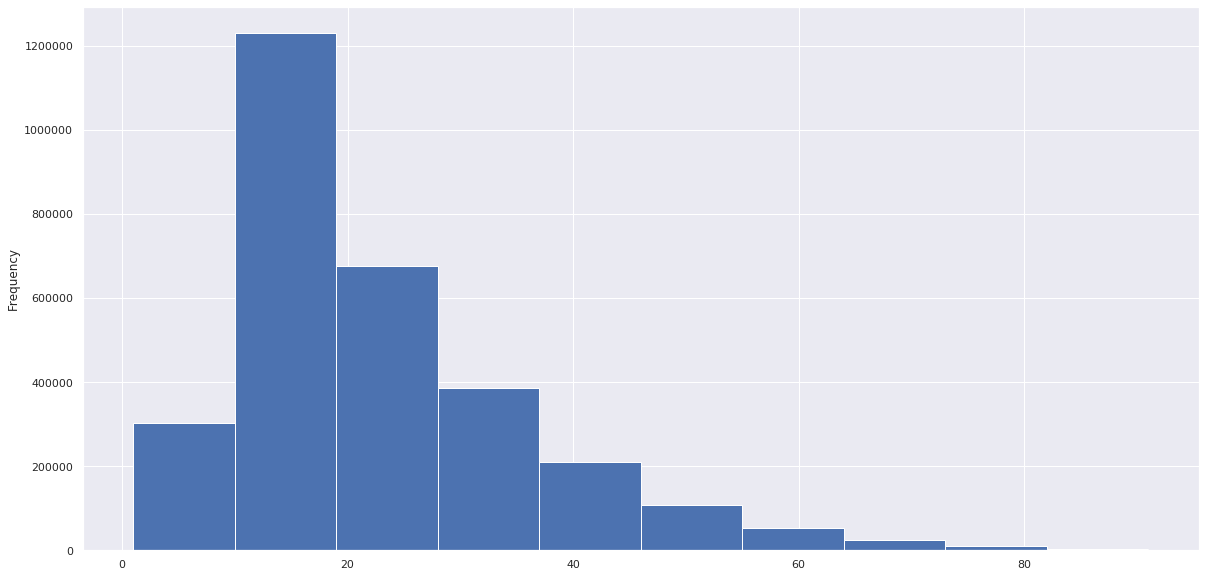

In [22]:
train_clicking_behavior_df['len_clicking_day_sequence_in_day_unit'].plot(kind='hist')

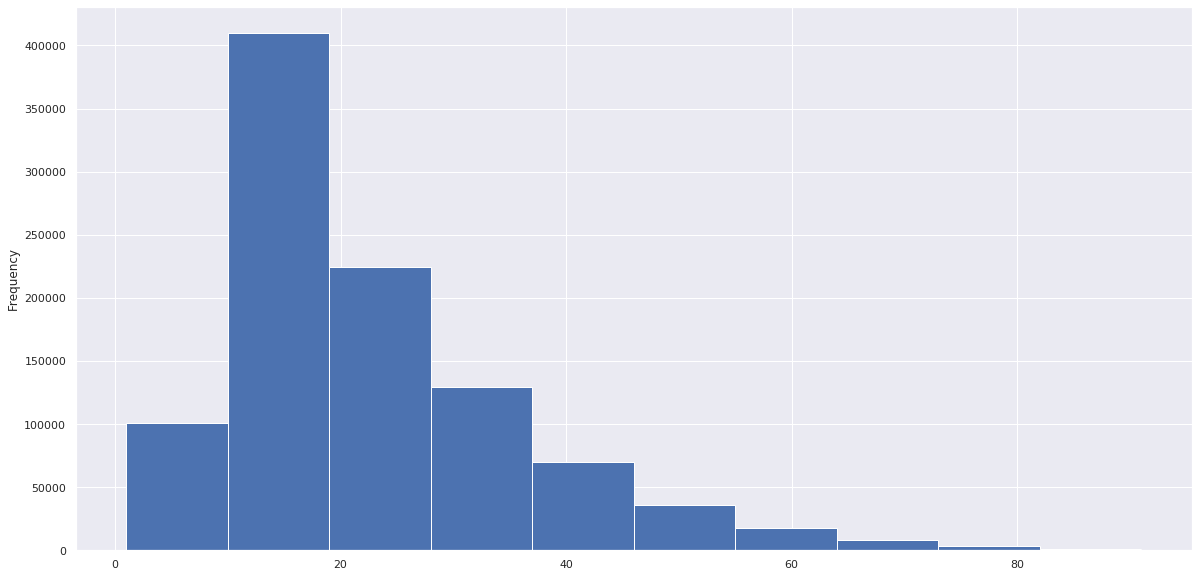

In [23]:
test_clicking_behavior_df['len_clicking_day_sequence_in_day_unit'].plot(kind='hist')

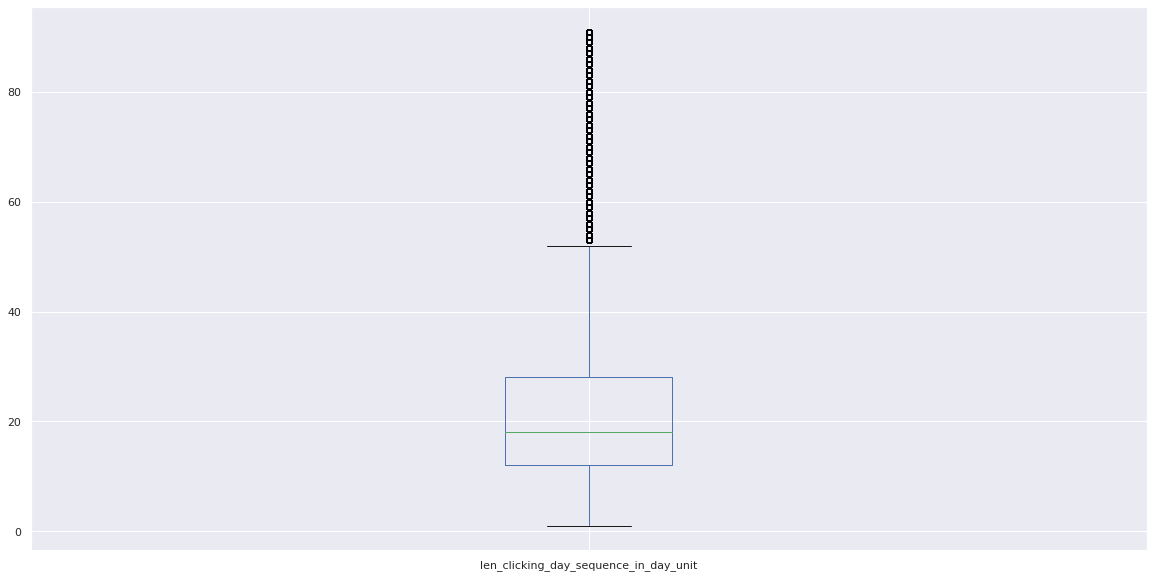

In [25]:
train_clicking_behavior_df['len_clicking_day_sequence_in_day_unit'].plot(kind='box')

In [26]:
mask = train_clicking_behavior_df['len_clicking_day_sequence_in_day_unit']>=52
len(train_clicking_behavior_df[mask]) / len(train_clicking_behavior_df)

0.03900733333333333

In [27]:
train_clicking_behavior_df['len_clicking_day_sequence_in_day_unit'].describe()

count    3.000000e+06
mean     2.200311e+01
std      1.306038e+01
min      1.000000e+00
25%      1.200000e+01
50%      1.800000e+01
75%      2.800000e+01
max      9.100000e+01
Name: len_clicking_day_sequence_in_day_unit, dtype: float64

In [28]:
test_clicking_behavior_df['len_clicking_day_sequence_in_day_unit'].describe()

count    1000000.000000
mean          22.005399
std           13.071768
min            1.000000
25%           12.000000
50%           18.000000
75%           28.000000
max           91.000000
Name: len_clicking_day_sequence_in_day_unit, dtype: float64

In [29]:
train_clicking_behavior_df['len_clicking_day_sequence'].describe()

count    3.000000e+06
mean     6.578749e+01
std      1.056383e+02
min      4.000000e+00
25%      3.000000e+01
50%      4.600000e+01
75%      7.800000e+01
max      7.211300e+04
Name: len_clicking_day_sequence, dtype: float64

In [30]:
test_clicking_behavior_df['len_clicking_day_sequence'].describe()

count    1000000.000000
mean          33.585512
std          126.100693
min            2.000000
25%           15.000000
50%           24.000000
75%           40.000000
max       113974.000000
Name: len_clicking_day_sequence, dtype: float64

### <a id='3'> 3. analysis creative id clicked by user</a>

In [32]:
def generate_user_clicking_creative_df(df):
    tmp_df = df[['user_id','creative_id']]
    tmp_df = tmp_df.groupby(['user_id'])['creative_id'].apply(list)
    tmp_df = pd.DataFrame(tmp_df).reset_index()
    tmp_df.columns = ['user_id','clicking_creative_seq']
    tmp_df['len_clicking_creative_seq'] = tmp_df['clicking_creative_seq'].apply(len)
    tmp_df['unique_len_clicking_creative_seq'] = tmp_df['clicking_creative_seq'].apply(set).apply(len)
    
    return tmp_df

In [33]:
train_user_clicking_creative_df = generate_user_clicking_creative_df(raw_train_df)

In [36]:
train_user_clicking_creative_df.head()

,user_id,clicking_creative_seq,len_clicking_creative_seq,unique_len_clicking_creative_seq
0,1,"[877468, 877468, 821396, 821396, 209778, 20977...",26,12
1,2,"[63441, 63441, 155822, 155822, 39714, 39714, 6...",89,42
2,3,"[661347, 661347, 808612, 808612, 593522, 59352...",58,30
3,4,"[39588, 39588, 589886, 589886, 574787, 574787,...",58,29
4,5,"[296145, 296145, 350759, 350759, 24333, 24333,...",65,33


In [37]:
train_user_clicking_creative_df['len_clicking_creative_seq'].describe()

count    3.000000e+06
mean     6.578749e+01
std      1.056383e+02
min      4.000000e+00
25%      3.000000e+01
50%      4.600000e+01
75%      7.800000e+01
max      7.211300e+04
Name: len_clicking_creative_seq, dtype: float64

In [20]:
train_user_clicking_creative_df['len_clicking_creative_seq'].describe()

count    900000.000000
mean         33.425301
std          36.082709
min           2.000000
25%          15.000000
50%          24.000000
75%          40.000000
max       16868.000000
Name: len_clicking_creative_seq, dtype: float64

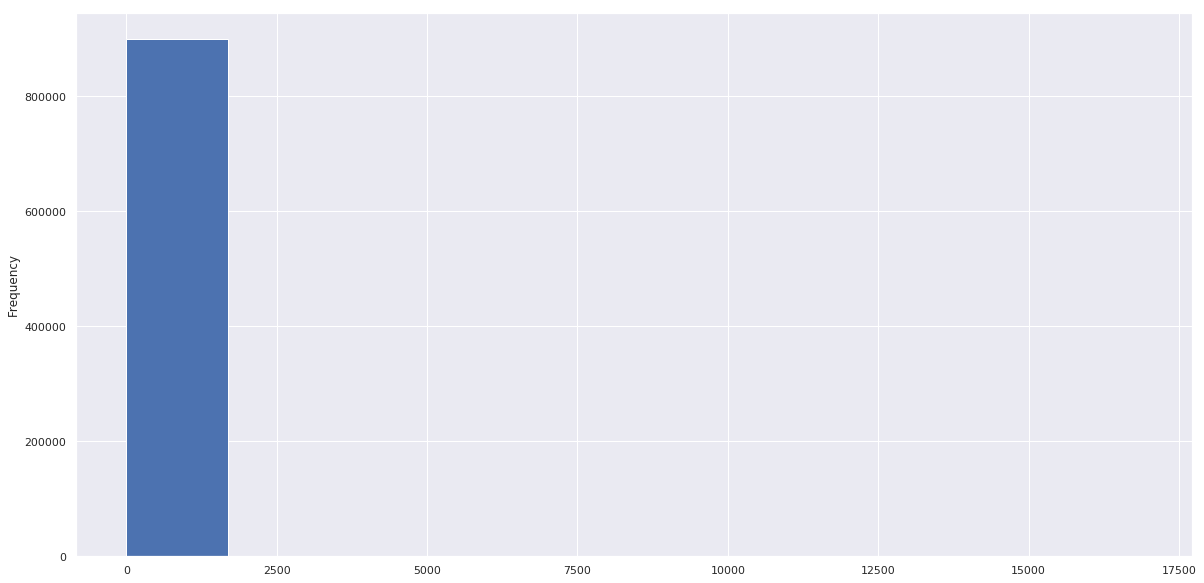

In [21]:
train_user_clicking_creative_df['len_clicking_creative_seq'].plot(kind='hist')

### <a id='4'> 4. analysis product category clicked by user</a>

In [9]:
def generate_user_clicking_product_cate_df(df):
    tmp_df = df[['user_id','product_category']]
    tmp_df = tmp_df.groupby(['user_id'])['product_category'].apply(list).reset_index()
    tmp_df['len_clicking_product_cate_sequence'] = tmp_df['product_category'].apply(len)
    tmp_df['unique_len_clicking_creative_sequence'] = tmp_df['product_category'].apply(set).apply(len)
    
    return tmp_df

In [10]:
train_user_clicking_product_cate_df = generate_user_clicking_product_cate_df(raw_train_df)

In [11]:
train_user_clicking_product_cate_df.describe()

,user_id,len_clicking_product_cate_sequence,unique_len_clicking_creative_sequence
count,900000.000000,900000.000000,900000.000000
mean,450000.500000,33.425301,3.825760
std,259807.765473,36.082709,1.263451
min,1.000000,2.000000,1.000000
25%,225000.750000,15.000000,3.000000
50%,450000.500000,24.000000,4.000000
75%,675000.250000,40.000000,5.000000
max,900000.000000,16868.000000,12.000000


In [12]:
train_user_clicking_product_cate_df.head()

,user_id,product_category,len_clicking_product_cate_sequence,unique_len_clicking_creative_sequence
0,1,"[5, 5, 2, 5, 2, 18, 5, 5, 18, 2, 2, 2, 2]",13,3
1,2,"[2, 2, 2, 2, 2, 18, 2, 18, 2, 18, 2, 18, 2, 18...",45,3
2,3,"[17, 17, 2, 17, 2, 18, 18, 2, 2, 2, 18, 12, 2,...",30,6
3,4,"[2, 18, 2, 17, 17, 17, 17, 4, 18, 2, 2, 2, 2, ...",29,6
4,5,"[5, 8, 2, 2, 18, 2, 5, 18, 18, 2, 18, 2, 5, 5,...",33,4


### <a id='5'> 5. analysis ad id clicked by user</a>

In [19]:
def generate_user_clicking_ad_id_df(df):
    tmp_df = df[['user_id','ad_id']]
    tmp_df = tmp_df.groupby(['user_id'])['ad_id'].apply(list).reset_index()
    tmp_df['len_clicking_ad_id_sequence'] = tmp_df['ad_id'].apply(len)
    tmp_df['unique_len_clicking_ad_id'] = tmp_df['ad_id'].apply(set).apply(len)
    return tmp_df

In [20]:
train_user_clicking_ad_df = generate_user_clicking_ad_id_df(raw_train_df)

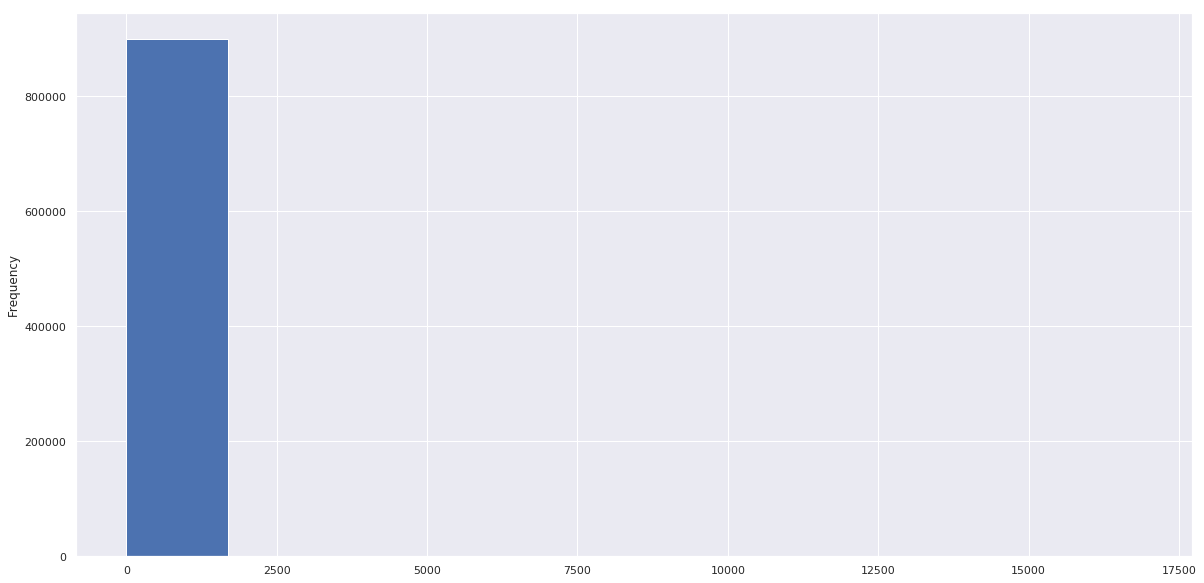

In [24]:
train_user_clicking_ad_df['len_clicking_ad_id_sequence'].plot(kind='hist')

In [22]:
train_user_clicking_ad_df.describe()

,user_id,len_clicking_ad_id_sequence,unique_len_clicking_ad_id
count,900000.000000,900000.000000,900000.000000
mean,450000.500000,33.425301,30.623978
std,259807.765473,36.082709,29.727181
min,1.000000,2.000000,1.000000
25%,225000.750000,15.000000,14.000000
50%,450000.500000,24.000000,22.000000
75%,675000.250000,40.000000,37.000000
max,900000.000000,16868.000000,10870.000000


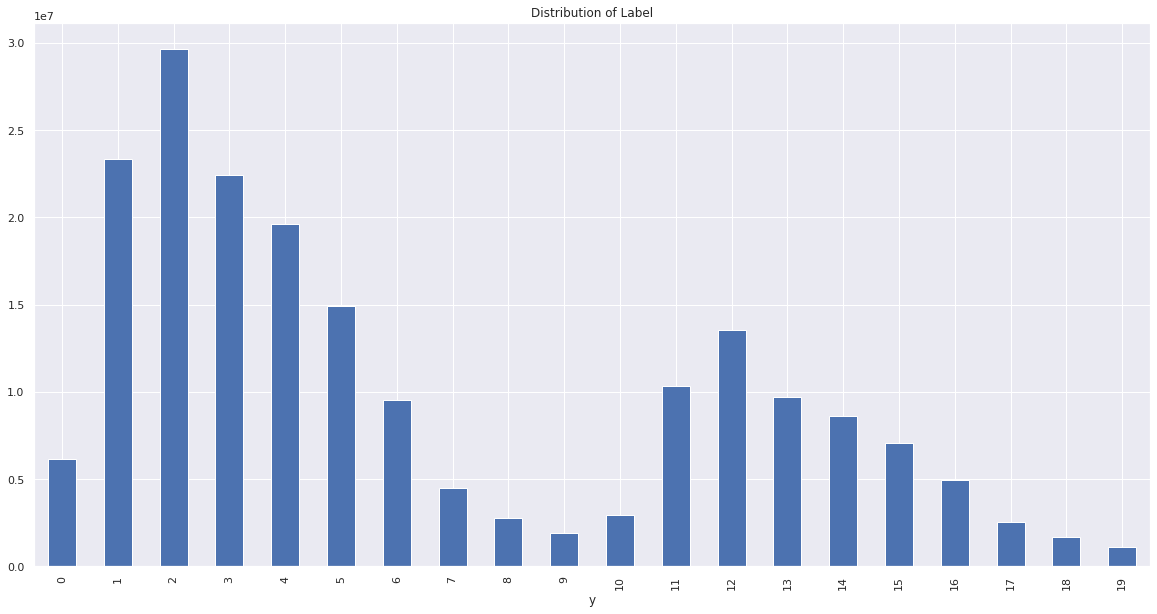

In [35]:
tmp_df = raw_train_df.groupby(['y']).apply(len)
tmp_df.plot(
            kind='bar',
            title='Distribution of Label',
)

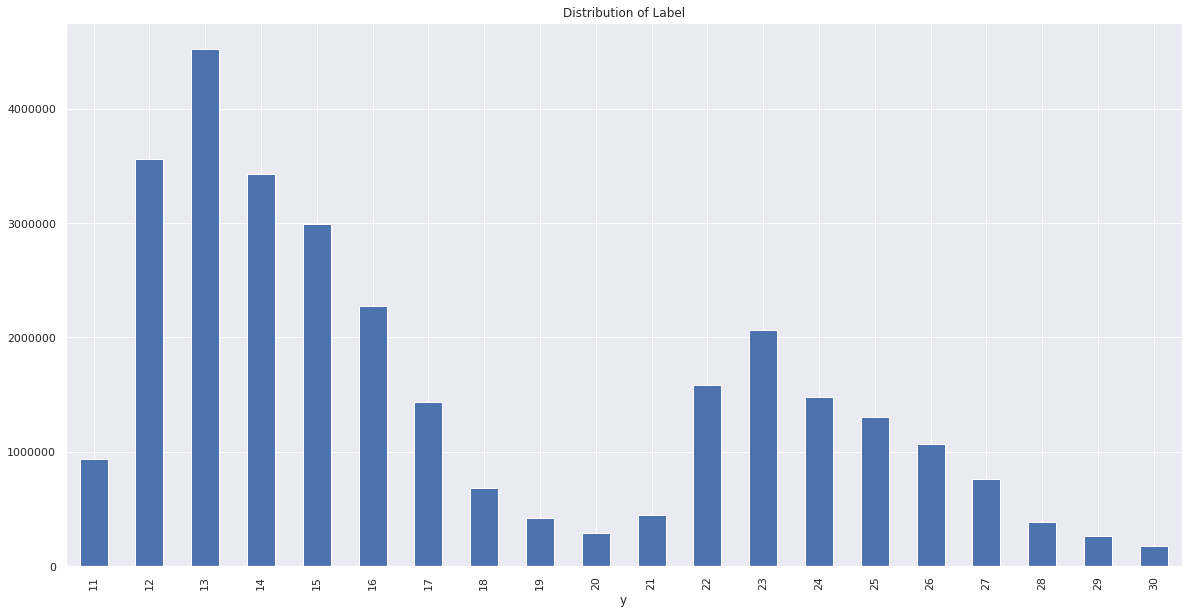

In [13]:
# label distribution
tmp_df = raw_train_df.groupby(['y']).apply(len)
tmp_df.plot(
            kind='bar',
            title='Distribution of Label',
)

In [14]:
tmp_df

y
11     941413
12    3559101
13    4524352
14    3426689
15    2988624
16    2273504
17    1439654
18     680058
19     423781
20     290397
21     450684
22    1583283
23    2061842
24    1481065
25    1306577
26    1067122
27     764694
28     385440
29     261304
30     173187
dtype: int64

In [22]:
prob_list = (tmp_df/len(raw_train_df)).values.tolist()

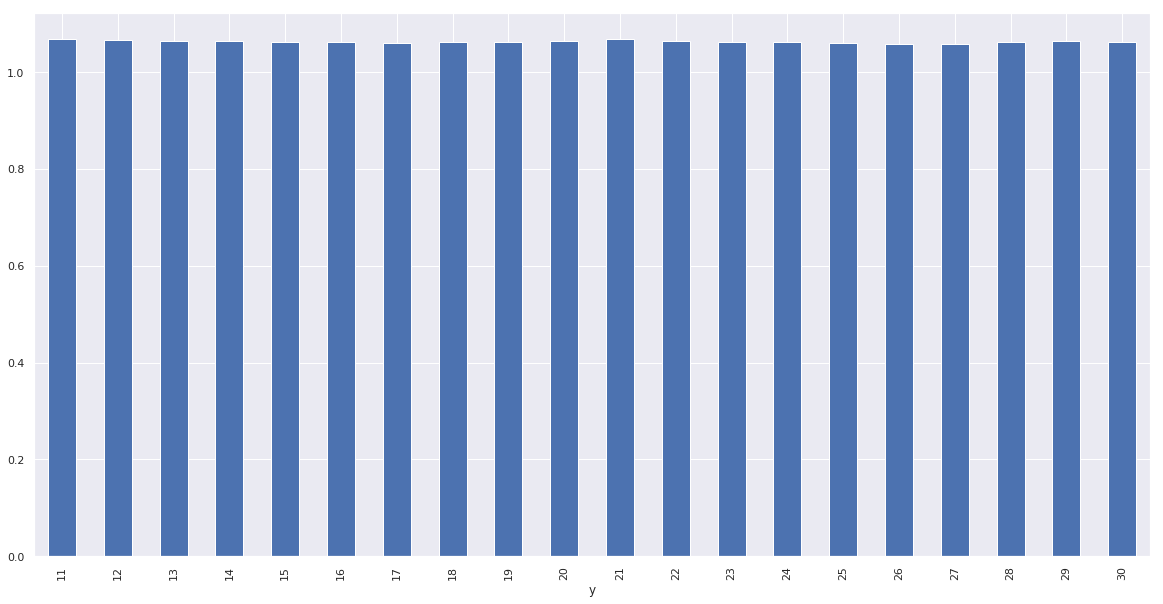

In [9]:
tmp_df = raw_train_df.groupby(['y'])['click_times'].apply(list).apply(np.mean)
tmp_df.plot(kind='bar')

In [32]:
tmp_df

y
11    1.068931
12    1.065789
13    1.063840
14    1.064102
15    1.062894
16    1.062365
17    1.060069
18    1.061262
19    1.061244
20    1.063282
21    1.069239
22    1.063428
23    1.062037
24    1.062156
25    1.060968
26    1.057942
27    1.057797
28    1.062378
29    1.065276
30    1.062868
Name: click_times, dtype: float64